# Install

In [1]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


You should consider upgrading via the 'C:\Users\Deniz\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [2]:
!pip install stable-baselines3[extra] protobuf==3.20.*

You should consider upgrading via the 'C:\Users\Deniz\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [3]:
!pip install mss pydirectinput pytesseract gym

You should consider upgrading via the 'C:\Users\Deniz\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [4]:
import numpy as np
from mss import mss
import pydirectinput
import pytesseract
from matplotlib import pyplot as plt
import time
from gym import Env
from gym.spaces import Box, Discrete, MultiDiscrete, Tuple
import copy
import random
import pygame
import threading
import os 
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker
import sys
from stable_baselines3 import DQN, A2C, PPO
import matplotlib.pyplot as plt

In [6]:
def list_to_array(list):
    updated_list = []
    for sublist in list:
        updated_sublist = []
        for i in sublist:
            updated_sublist.append(i+1)
        updated_list.append(updated_sublist)
    for sublist in updated_list:
        while len(sublist)<4:
            sublist.append(0)
    while len(updated_list) < 8:
        updated_list.append([-1,-1,-1,-1])
    return np.array(updated_list)

# Level 1, 2 & 3

In [7]:
class WaterSortGame_1:
    def __init__(self):
        pygame.init()
        self.WIDTH = 500
        self.HEIGHT = 550
        self.screen = pygame.display.set_mode([self.WIDTH, self.HEIGHT])
        pygame.display.set_caption('Water Sort PyGame')
        self.font = pygame.font.Font('freesansbold.ttf', 24)
        self.fps = 120
        self.timer = pygame.time.Clock()
        self.color_choices = ['red', 'orange', 'light blue', 'dark blue', 'dark green', 'pink', 'purple', 'dark gray',
                              'brown', 'light green', 'yellow', 'white']
        self.tube_colors = []
        self.initial_colors = []
        self.tubes_number = 4
        self.new_game = True
        self.selected = False
        self.tube_rects = []
        self.select_rect = 100
        self.win = False
        self.level = 1
        self.zeros_ones = []
        self.previous_zeros_ones = self.zeros_ones
        self.current_zeros_ones = []
        self.reward = 0
        self.total_reward = 0

    def generate_start(self):
        tubes_colors = []
        available_colors = []
        for i in range(self.tubes_number):
            tubes_colors.append([])
            if i < self.tubes_number - 2:
                for j in range(4):
                    available_colors.append(i)
        for i in range(self.tubes_number - 2):
            for j in range(4):
                random.seed(12)
                color = random.choice(available_colors)
                tubes_colors[i].append(color)
                available_colors.remove(color)
        #print(tubes_colors)
        #print(self.tubes_number)
        return tubes_colors

    def draw_tubes(self, tubes_num, tube_cols):
        tube_boxes = []
        if tubes_num % 2 == 0:
            tubes_per_row = tubes_num // 2
            offset = False
        else:
            tubes_per_row = tubes_num // 2 + 1
            offset = True
        spacing = self.WIDTH / tubes_per_row
        for i in range(tubes_per_row):
            for j in range(len(tube_cols[i])):
                pygame.draw.rect(self.screen, self.color_choices[tube_cols[i][j]], [5 + spacing * i, 200 - (50 * j), 65, 50], 0, 3)
            box = pygame.draw.rect(self.screen, 'blue', [5 + spacing * i, 50, 65, 200], 5, 5)
            if self.select_rect == i:
                pygame.draw.rect(self.screen, 'green', [5 + spacing * i, 50, 65, 200], 3, 5)
            tube_boxes.append(box)
        if offset:
            for i in range(tubes_per_row - 1):
                for j in range(len(tube_cols[i + tubes_per_row])):
                    pygame.draw.rect(self.screen, self.color_choices[tube_cols[i + tubes_per_row][j]],
                                     [(spacing * 0.5) + 5 + spacing * i, 450 - (50 * j), 65, 50], 0, 3)
                box = pygame.draw.rect(self.screen, 'blue', [(spacing * 0.5) + 5 + spacing * i, 300, 65, 200], 5, 5)
                if self.select_rect == i + tubes_per_row:
                    pygame.draw.rect(self.screen, 'green', [(spacing * 0.5) + 5 + spacing * i, 300, 65, 200], 3, 5)
                tube_boxes.append(box)
        else:
            for i in range(tubes_per_row):
                for j in range(len(tube_cols[i + tubes_per_row])):
                    pygame.draw.rect(self.screen, self.color_choices[tube_cols[i + tubes_per_row][j]], [5 + spacing * i,
                                                                                              450 - (50 * j), 65, 50], 0, 3)
                box = pygame.draw.rect(self.screen, 'blue', [5 + spacing * i, 300, 65, 200], 5, 5)
                if self.select_rect == i + tubes_per_row:
                    pygame.draw.rect(self.screen, 'green', [5 + spacing * i, 300, 65, 200], 3, 5)
                tube_boxes.append(box)
        return tube_boxes

    def calc_move(self, colors, selected_rect, destination):

        self.check_fullcolor()
        current = self.zeros_ones
        #print(current)
        
        chain = True
        color_on_top = 100
        length = 1
        color_to_move = 100
        if len(colors[selected_rect]) > 0:
            color_to_move = colors[selected_rect][-1]
            for i in range(1, len(colors[selected_rect])):
                if chain:
                    if colors[selected_rect][-1 - i] == color_to_move:
                        length += 1
                    else:
                        chain = False
        if 4 > len(colors[destination]):
            if len(colors[destination]) == 0:
                color_on_top = color_to_move
            else:
                color_on_top = colors[destination][-1]
        if color_on_top == color_to_move:
            for i in range(length):
                if len(colors[destination]) < 4:
                    if len(colors[selected_rect]) > 0:
                        colors[destination].append(color_on_top)
                        colors[selected_rect].pop(-1)
        self.check_fullcolor()
        next = self.zeros_ones
        #print(next)
        #print(self.get_reward(current, next))
        #print(colors, length)
        return colors


    def run_game(self):
        run = True
        while run:
            self.screen.fill('black')
            self.timer.tick(self.fps)
            if self.new_game:
                self.tube_colors = self.generate_start()
                self.initial_colors = copy.deepcopy(self.tube_colors)
                self.new_game = False
                self.zeros_ones = [0] * (self.tubes_number -2)
            else:
                self.tube_rects = self.draw_tubes(self.tubes_number, self.tube_colors)
            self.win = self.check_victory(self.tube_colors)
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    run = False  
                elif event.type == pygame.KEYDOWN and event.key == pygame.K_q: # burda değişiklik
                    run = False # burda değişiklik
                if event.type == pygame.KEYUP:
                    if event.key == pygame.K_SPACE:
                        self.tube_colors = copy.deepcopy(self.initial_colors)
                    elif event.key == pygame.K_RETURN:
                        self.new_game = True
                        self.level += 1  # Leveli bir arttır
                        if self.level > 40:
                            self.tubes_number = 8
                        elif self.level > 30:
                            self.tubes_number = 7
                        elif self.level > 20:
                            self.tubes_number = 6
                        elif self.level > 10:
                            self.tubes_number = 5
                            
                if event.type == pygame.KEYDOWN:

                    if not self.selected:
                        if event.key == pygame.K_1:
                            self.select_rect = 0
                            self.selected = True
                        elif event.key == pygame.K_2:
                            self.select_rect = 1
                            self.selected = True
                        elif event.key == pygame.K_3:
                            self.select_rect = 2
                            self.selected = True
                        elif event.key == pygame.K_4:
                            self.select_rect = 3
                            self.selected = True
                        elif event.key == pygame.K_5:
                            self.select_rect = 4
                            self.selected = True
                        elif event.key == pygame.K_6:
                            self.select_rect = 5
                            self.selected = True
                        elif event.key == pygame.K_7:
                            self.select_rect = 6
                            self.selected = True
                        elif event.key == pygame.K_8:
                            self.select_rect = 7
                            self.selected = True
                        elif event.key == pygame.K_9:
                            self.select_rect = 8
                            self.selected = True
                        """for item in range(len(self.tube_rects)):
                            if self.tube_rects[item].collidepoint(event.pos):
                                self.selected = True
                                self.select_rect = item"""
                    else:

                        if event.key == pygame.K_1:
                            dest_rect = 0
                        elif event.key == pygame.K_2:
                            dest_rect = 1
                        elif event.key == pygame.K_3:
                            dest_rect = 2
                        elif event.key == pygame.K_4:
                            dest_rect = 3
                        elif event.key == pygame.K_5:
                            dest_rect = 4
                        elif event.key == pygame.K_6:
                            dest_rect = 5
                        elif event.key == pygame.K_7:
                            dest_rect = 6
                        elif event.key == pygame.K_8:
                            dest_rect = 7
                        elif event.key == pygame.K_9:
                            dest_rect = 8

                        
                        
                        """for item in range(len(self.tube_rects)):
                            if self.tube_rects[item].collidepoint(event.pos):
                                dest_rect = item"""
                        self.tube_colors = self.calc_move(self.tube_colors, self.select_rect, dest_rect)
                        self.selected = False
                        self.select_rect = 100

            self.display_texts()
            self.display_level()
            self.display_reward()# Yeni eklenen fonksiyonu çağır
            pygame.display.flip()

        pygame.quit()
        sys.exit() # burda değişiklik

    def display_texts(self):
        if self.win:
            victory_text = self.font.render('You Won! Press Enter for a new board!', True, 'white')
            self.screen.blit(victory_text, (30, 265))
        restart_text = self.font.render('Stuck? Space-Restart, Enter-New Board!', True, 'white')
        self.screen.blit(restart_text, (10, 10))

    def display_level(self):
        level_text = self.font.render(f'Level: {self.level}', True, 'white')
        text_rect = level_text.get_rect(topleft=(10, self.HEIGHT - 30))  # Update topleft instead of center
        self.screen.blit(level_text, text_rect)

    def display_reward(self):
        reward_text = self.font.render(f'Reward: {self.reward}', True, 'white')
        text_rect = reward_text.get_rect(topleft=(250, self.HEIGHT - 30))  # Update topleft instead of center
        self.screen.blit(reward_text, text_rect)
    
    def check_fullcolor(self):
    
        for i in self.tube_colors:
            if len(i) == 4:
                if all(x == i[0] for x in i):
                    self.zeros_ones[i[0]] = 1
                
        return self.zeros_ones
        

    def check_victory(self, colors):
        won = True
        for i in range(len(colors)):
            if len(colors[i]) > 0:
                if len(colors[i]) != 4:
                    won = False
                else:
                    main_color = colors[i][-1]
                    for j in range(len(colors[i])):
                        if colors[i][j] != main_color:
                            won = False
        return won

    def get_reward(self, current, next):
        self.reward = 0
        print(current, next)
    
        for i in range(len(current)):
            # Mevcut durumda 0 iken, bir sonraki durumda 1 olduysa 10 puan ekle
            if current[i] == 0 and next[i] == 1:
                self.reward += 5
    
        return self.reward


In [8]:
class Agent_1(Env):
    def __init__(self):
        super().__init__()
        self.game = None
        self.game_thread = threading.Thread(target=self.run_game_in_thread)
        self.game_thread.daemon = True  # Bu, program sonlandığında thread'in de sonlanmasını sağlar
        self.game_thread.start()

        self.level = 1
        self.action_space = MultiDiscrete([8, 8])
        self.action_number = 0
        self.invalid_action_counter = 0
        self.last_three_observation = []
        self.observation_space = Box(low=-1, high=6, shape=(8, 4), dtype=int)

    def step(self, action):
        self.action_number += 1
        action_type = None
        reward = 0
        done = False
        info = {}
        if len(self.last_three_observation) == 0:
            self.last_three_observation.append(self.get_observation())
        obs_list = copy.deepcopy(self.last_three_observation)



        if self.game.win == False:
            if len(obs_list[-1]) > max(action[0], action[1]):
                pydirectinput.press(str(action[0]+1))
                #time.sleep(0.1)
                pydirectinput.press(str(action[1]+1))
        

        
        observation = copy.deepcopy(self.get_observation())
        
        if self.game.win:
            reward = 10 # Get reward
            #self.game.reward += reward
            done = True
            pydirectinput.press("enter")
            time.sleep(0.3)
            action_type = "WON"

        
        else:
            if len(obs_list) == 4:
                obs_list.pop(0)

            if action[0] == action[1]:
                #reward = -1
                action_type = "Select=Destination"
                self.invalid_action_counter += 1

            elif sorted(obs_list[-1]) == sorted(observation):
                #reward = -1
                action_type = "Not Changed"
                self.invalid_action_counter += 1

            elif len(obs_list) == 2 and sorted(obs_list[-2]) == sorted(observation):
                #reward = -1
                action_type = "Iteration"
                self.invalid_action_counter += 1

            elif len(obs_list) == 3 and (sorted(obs_list[-2]) == sorted(observation) or sorted(obs_list[-3]) == sorted(observation)):
                #reward = -1
                action_type = "Iteration"
                self.invalid_action_counter += 1

            elif self.check_fullcolor(observation) > self.check_fullcolor(obs_list[-1]):
                reward = 5
                action_type = "Fullcolor"
                obs_list.append(observation)
                self.invalid_action_counter = 0

            else:
                reward = 1
                action_type = "Valid Action"
                obs_list.append(observation)
                self.invalid_action_counter = 0
        self.game.reward += reward
        if done == False:
            done = self.get_done()
        self.last_three_observation = copy.deepcopy(obs_list)
        self.level = self.game.level
        #print(action, action_type, "ActionCounter:", self.action_number)
        #print(observation)
        #print()
        return list_to_array(observation), reward, done, info
    
    def render(self):
        pass

    def reset(self):
        #print(self.level)
        self.game.reward = 0
        observation = self.get_observation()
        #print(observation)
        #print()
        self.action_number = 0
        self.invalid_action_counter = 0
        self.last_three_observation = []
        self.previous_action = None
        
        pydirectinput.press("space")

        return list_to_array(observation)

    def close(self):   #ok
        cv2.destroyAllWindows()

    def get_done(self):
        done = False
        if self.action_number > 99:
            done = True
        return done

    def get_observation(self):
        obs = self.game.tube_colors
        return obs

    def run_game_in_thread(self):
        self.game = WaterSortGame_1()
        self.game.run_game()

    def check_fullcolor(self, obs):
        x = 0
        for i in obs:
            if len(i) == 4:
                if all(x == i[0] for x in i):
                    x += 1
        return x


In [9]:
env = Agent_1()

In [9]:
class WaterSortGame_2:
    def __init__(self):
        pygame.init()
        self.WIDTH = 500
        self.HEIGHT = 550
        self.screen = pygame.display.set_mode([self.WIDTH, self.HEIGHT])
        pygame.display.set_caption('Water Sort PyGame')
        self.font = pygame.font.Font('freesansbold.ttf', 24)
        self.fps = 120
        self.timer = pygame.time.Clock()
        self.color_choices = ['red', 'orange', 'light blue', 'dark blue', 'dark green', 'pink', 'purple', 'dark gray',
                              'brown', 'light green', 'yellow', 'white']
        self.tube_colors = []
        self.initial_colors = []
        self.tubes_number = 5
        self.new_game = True
        self.selected = False
        self.tube_rects = []
        self.select_rect = 100
        self.win = False
        self.level = 11
        self.zeros_ones = []
        self.previous_zeros_ones = self.zeros_ones
        self.current_zeros_ones = []
        self.reward = 0
        self.total_reward = 0

    def generate_start(self):
        tubes_colors = []
        available_colors = []
        for i in range(self.tubes_number):
            tubes_colors.append([])
            if i < self.tubes_number - 2:
                for j in range(4):
                    available_colors.append(i)
        for i in range(self.tubes_number - 2):
            for j in range(4):
                random.seed(1)
                color = random.choice(available_colors)
                tubes_colors[i].append(color)
                available_colors.remove(color)
        #print(tubes_colors)
        #print(self.tubes_number)
        return tubes_colors

    def draw_tubes(self, tubes_num, tube_cols):
        tube_boxes = []
        if tubes_num % 2 == 0:
            tubes_per_row = tubes_num // 2
            offset = False
        else:
            tubes_per_row = tubes_num // 2 + 1
            offset = True
        spacing = self.WIDTH / tubes_per_row
        for i in range(tubes_per_row):
            for j in range(len(tube_cols[i])):
                pygame.draw.rect(self.screen, self.color_choices[tube_cols[i][j]], [5 + spacing * i, 200 - (50 * j), 65, 50], 0, 3)
            box = pygame.draw.rect(self.screen, 'blue', [5 + spacing * i, 50, 65, 200], 5, 5)
            if self.select_rect == i:
                pygame.draw.rect(self.screen, 'green', [5 + spacing * i, 50, 65, 200], 3, 5)
            tube_boxes.append(box)
        if offset:
            for i in range(tubes_per_row - 1):
                for j in range(len(tube_cols[i + tubes_per_row])):
                    pygame.draw.rect(self.screen, self.color_choices[tube_cols[i + tubes_per_row][j]],
                                     [(spacing * 0.5) + 5 + spacing * i, 450 - (50 * j), 65, 50], 0, 3)
                box = pygame.draw.rect(self.screen, 'blue', [(spacing * 0.5) + 5 + spacing * i, 300, 65, 200], 5, 5)
                if self.select_rect == i + tubes_per_row:
                    pygame.draw.rect(self.screen, 'green', [(spacing * 0.5) + 5 + spacing * i, 300, 65, 200], 3, 5)
                tube_boxes.append(box)
        else:
            for i in range(tubes_per_row):
                for j in range(len(tube_cols[i + tubes_per_row])):
                    pygame.draw.rect(self.screen, self.color_choices[tube_cols[i + tubes_per_row][j]], [5 + spacing * i,
                                                                                              450 - (50 * j), 65, 50], 0, 3)
                box = pygame.draw.rect(self.screen, 'blue', [5 + spacing * i, 300, 65, 200], 5, 5)
                if self.select_rect == i + tubes_per_row:
                    pygame.draw.rect(self.screen, 'green', [5 + spacing * i, 300, 65, 200], 3, 5)
                tube_boxes.append(box)
        return tube_boxes

    def calc_move(self, colors, selected_rect, destination):

        self.check_fullcolor()
        current = self.zeros_ones
        #print(current)
        
        chain = True
        color_on_top = 100
        length = 1
        color_to_move = 100
        if len(colors[selected_rect]) > 0:
            color_to_move = colors[selected_rect][-1]
            for i in range(1, len(colors[selected_rect])):
                if chain:
                    if colors[selected_rect][-1 - i] == color_to_move:
                        length += 1
                    else:
                        chain = False
        if 4 > len(colors[destination]):
            if len(colors[destination]) == 0:
                color_on_top = color_to_move
            else:
                color_on_top = colors[destination][-1]
        if color_on_top == color_to_move:
            for i in range(length):
                if len(colors[destination]) < 4:
                    if len(colors[selected_rect]) > 0:
                        colors[destination].append(color_on_top)
                        colors[selected_rect].pop(-1)
        self.check_fullcolor()
        next = self.zeros_ones
        #print(next)
        #print(self.get_reward(current, next))
        #print(colors, length)
        return colors


    def run_game(self):
        run = True
        while run:
            self.screen.fill('black')
            self.timer.tick(self.fps)
            if self.new_game:
                self.tube_colors = self.generate_start()
                self.initial_colors = copy.deepcopy(self.tube_colors)
                self.new_game = False
                self.zeros_ones = [0] * (self.tubes_number -2)
            else:
                self.tube_rects = self.draw_tubes(self.tubes_number, self.tube_colors)
            self.win = self.check_victory(self.tube_colors)
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    run = False  
                elif event.type == pygame.KEYDOWN and event.key == pygame.K_q: # burda değişiklik
                    run = False # burda değişiklik
                if event.type == pygame.KEYUP:
                    if event.key == pygame.K_SPACE:
                        self.tube_colors = copy.deepcopy(self.initial_colors)
                    elif event.key == pygame.K_RETURN:
                        self.new_game = True
                        self.level += 1  # Leveli bir arttır
                        if self.level > 40:
                            self.tubes_number = 8
                        elif self.level > 30:
                            self.tubes_number = 7
                        elif self.level > 20:
                            self.tubes_number = 6
                        elif self.level > 10:
                            self.tubes_number = 5
                            
                if event.type == pygame.KEYDOWN:

                    if not self.selected:
                        if event.key == pygame.K_1:
                            self.select_rect = 0
                            self.selected = True
                        elif event.key == pygame.K_2:
                            self.select_rect = 1
                            self.selected = True
                        elif event.key == pygame.K_3:
                            self.select_rect = 2
                            self.selected = True
                        elif event.key == pygame.K_4:
                            self.select_rect = 3
                            self.selected = True
                        elif event.key == pygame.K_5:
                            self.select_rect = 4
                            self.selected = True
                        elif event.key == pygame.K_6:
                            self.select_rect = 5
                            self.selected = True
                        elif event.key == pygame.K_7:
                            self.select_rect = 6
                            self.selected = True
                        elif event.key == pygame.K_8:
                            self.select_rect = 7
                            self.selected = True
                        elif event.key == pygame.K_9:
                            self.select_rect = 8
                            self.selected = True
                        """for item in range(len(self.tube_rects)):
                            if self.tube_rects[item].collidepoint(event.pos):
                                self.selected = True
                                self.select_rect = item"""
                    else:

                        if event.key == pygame.K_1:
                            dest_rect = 0
                        elif event.key == pygame.K_2:
                            dest_rect = 1
                        elif event.key == pygame.K_3:
                            dest_rect = 2
                        elif event.key == pygame.K_4:
                            dest_rect = 3
                        elif event.key == pygame.K_5:
                            dest_rect = 4
                        elif event.key == pygame.K_6:
                            dest_rect = 5
                        elif event.key == pygame.K_7:
                            dest_rect = 6
                        elif event.key == pygame.K_8:
                            dest_rect = 7
                        elif event.key == pygame.K_9:
                            dest_rect = 8

                        
                        
                        """for item in range(len(self.tube_rects)):
                            if self.tube_rects[item].collidepoint(event.pos):
                                dest_rect = item"""
                        self.tube_colors = self.calc_move(self.tube_colors, self.select_rect, dest_rect)
                        self.selected = False
                        self.select_rect = 100

            self.display_texts()
            self.display_level()
            self.display_reward()# Yeni eklenen fonksiyonu çağır
            pygame.display.flip()

        pygame.quit()
        sys.exit() # burda değişiklik

    def display_texts(self):
        if self.win:
            victory_text = self.font.render('You Won! Press Enter for a new board!', True, 'white')
            self.screen.blit(victory_text, (30, 265))
        restart_text = self.font.render('Stuck? Space-Restart, Enter-New Board!', True, 'white')
        self.screen.blit(restart_text, (10, 10))

    def display_level(self):
        level_text = self.font.render(f'Level: {self.level}', True, 'white')
        text_rect = level_text.get_rect(topleft=(10, self.HEIGHT - 30))  # Update topleft instead of center
        self.screen.blit(level_text, text_rect)

    def display_reward(self):
        reward_text = self.font.render(f'Reward: {self.reward}', True, 'white')
        text_rect = reward_text.get_rect(topleft=(250, self.HEIGHT - 30))  # Update topleft instead of center
        self.screen.blit(reward_text, text_rect)
    
    def check_fullcolor(self):
    
        for i in self.tube_colors:
            if len(i) == 4:
                if all(x == i[0] for x in i):
                    self.zeros_ones[i[0]] = 1
                
        return self.zeros_ones
        

    def check_victory(self, colors):
        won = True
        for i in range(len(colors)):
            if len(colors[i]) > 0:
                if len(colors[i]) != 4:
                    won = False
                else:
                    main_color = colors[i][-1]
                    for j in range(len(colors[i])):
                        if colors[i][j] != main_color:
                            won = False
        return won

    def get_reward(self, current, next):
        self.reward = 0
        print(current, next)
    
        for i in range(len(current)):
            # Mevcut durumda 0 iken, bir sonraki durumda 1 olduysa 10 puan ekle
            if current[i] == 0 and next[i] == 1:
                self.reward += 5
    
        return self.reward


In [10]:
class Agent_2(Env):
    def __init__(self):
        super().__init__()
        self.game = None
        self.game_thread = threading.Thread(target=self.run_game_in_thread)
        self.game_thread.daemon = True  # Bu, program sonlandığında thread'in de sonlanmasını sağlar
        self.game_thread.start()

        self.level = 1
        self.action_space = MultiDiscrete([8, 8])
        self.action_number = 0
        self.invalid_action_counter = 0
        self.last_three_observation = []
        self.observation_space = Box(low=-1, high=6, shape=(8, 4), dtype=int)

    def step(self, action):
        self.action_number += 1
        action_type = None
        reward = 0
        done = False
        info = {}
        if len(self.last_three_observation) == 0:
            self.last_three_observation.append(self.get_observation())
        obs_list = copy.deepcopy(self.last_three_observation)



        if self.game.win == False:
            if len(obs_list[-1]) > max(action[0], action[1]):
                pydirectinput.press(str(action[0]+1))
                #time.sleep(0.1)
                pydirectinput.press(str(action[1]+1))
        

        
        observation = copy.deepcopy(self.get_observation())
        
        if self.game.win:
            reward = 10 # Get reward
            #self.game.reward += reward
            done = True
            pydirectinput.press("enter")
            time.sleep(0.3)
            action_type = "WON"

        
        else:
            if len(obs_list) == 4:
                obs_list.pop(0)

            if action[0] == action[1]:
                #reward = -1
                action_type = "Select=Destination"
                self.invalid_action_counter += 1

            elif sorted(obs_list[-1]) == sorted(observation):
                #reward = -1
                action_type = "Not Changed"
                self.invalid_action_counter += 1

            elif len(obs_list) == 2 and sorted(obs_list[-2]) == sorted(observation):
                #reward = -1
                action_type = "Iteration"
                self.invalid_action_counter += 1

            elif len(obs_list) == 3 and (sorted(obs_list[-2]) == sorted(observation) or sorted(obs_list[-3]) == sorted(observation)):
                #reward = -1
                action_type = "Iteration"
                self.invalid_action_counter += 1

            elif self.check_fullcolor(observation) > self.check_fullcolor(obs_list[-1]):
                reward = 5
                action_type = "Fullcolor"
                obs_list.append(observation)
                self.invalid_action_counter = 0

            else:
                reward = 1
                action_type = "Valid Action"
                obs_list.append(observation)
                self.invalid_action_counter = 0
        self.game.reward += reward
        if done == False:
            done = self.get_done()
        self.last_three_observation = copy.deepcopy(obs_list)
        self.level = self.game.level
        #print(action, action_type, "ActionCounter:", self.action_number)
        #print(observation)
        #print()
        return list_to_array(observation), reward, done, info
    
    def render(self):
        pass

    def reset(self):
        #print(self.level)
        self.game.reward = 0
        observation = self.get_observation()
        #print(observation)
        #print()
        self.action_number = 0
        self.invalid_action_counter = 0
        self.last_three_observation = []
        self.previous_action = None
        
        pydirectinput.press("space")

        return list_to_array(observation)

    def close(self):   #ok
        cv2.destroyAllWindows()

    def get_done(self):
        done = False
        if self.action_number > 99:
            done = True
        return done

    def get_observation(self):
        obs = self.game.tube_colors
        return obs

    def run_game_in_thread(self):
        self.game = WaterSortGame_2()
        self.game.run_game()

    def check_fullcolor(self, obs):
        x = 0
        for i in obs:
            if len(i) == 4:
                if all(x == i[0] for x in i):
                    x += 1
        return x


In [169]:
env = Agent_2()

In [11]:
class WaterSortGame_3:
    def __init__(self):
        pygame.init()
        self.WIDTH = 500
        self.HEIGHT = 550
        self.screen = pygame.display.set_mode([self.WIDTH, self.HEIGHT])
        pygame.display.set_caption('Water Sort PyGame')
        self.font = pygame.font.Font('freesansbold.ttf', 24)
        self.fps = 120
        self.timer = pygame.time.Clock()
        self.color_choices = ['red', 'orange', 'light blue', 'dark blue', 'dark green', 'pink', 'purple', 'dark gray',
                              'brown', 'light green', 'yellow', 'white']
        self.tube_colors = []
        self.initial_colors = []
        self.tubes_number = 6
        self.new_game = True
        self.selected = False
        self.tube_rects = []
        self.select_rect = 100
        self.win = False
        self.level = 21
        self.zeros_ones = []
        self.previous_zeros_ones = self.zeros_ones
        self.current_zeros_ones = []
        self.reward = 0
        self.total_reward = 0

    def generate_start(self):
        tubes_colors = []
        available_colors = []
        for i in range(self.tubes_number):
            tubes_colors.append([])
            if i < self.tubes_number - 2:
                for j in range(4):
                    available_colors.append(i)
        for i in range(self.tubes_number - 2):
            for j in range(4):
                random.seed(1)
                color = random.choice(available_colors)
                tubes_colors[i].append(color)
                available_colors.remove(color)
        #print(tubes_colors)
        #print(self.tubes_number)
        return tubes_colors

    def draw_tubes(self, tubes_num, tube_cols):
        tube_boxes = []
        if tubes_num % 2 == 0:
            tubes_per_row = tubes_num // 2
            offset = False
        else:
            tubes_per_row = tubes_num // 2 + 1
            offset = True
        spacing = self.WIDTH / tubes_per_row
        for i in range(tubes_per_row):
            for j in range(len(tube_cols[i])):
                pygame.draw.rect(self.screen, self.color_choices[tube_cols[i][j]], [5 + spacing * i, 200 - (50 * j), 65, 50], 0, 3)
            box = pygame.draw.rect(self.screen, 'blue', [5 + spacing * i, 50, 65, 200], 5, 5)
            if self.select_rect == i:
                pygame.draw.rect(self.screen, 'green', [5 + spacing * i, 50, 65, 200], 3, 5)
            tube_boxes.append(box)
        if offset:
            for i in range(tubes_per_row - 1):
                for j in range(len(tube_cols[i + tubes_per_row])):
                    pygame.draw.rect(self.screen, self.color_choices[tube_cols[i + tubes_per_row][j]],
                                     [(spacing * 0.5) + 5 + spacing * i, 450 - (50 * j), 65, 50], 0, 3)
                box = pygame.draw.rect(self.screen, 'blue', [(spacing * 0.5) + 5 + spacing * i, 300, 65, 200], 5, 5)
                if self.select_rect == i + tubes_per_row:
                    pygame.draw.rect(self.screen, 'green', [(spacing * 0.5) + 5 + spacing * i, 300, 65, 200], 3, 5)
                tube_boxes.append(box)
        else:
            for i in range(tubes_per_row):
                for j in range(len(tube_cols[i + tubes_per_row])):
                    pygame.draw.rect(self.screen, self.color_choices[tube_cols[i + tubes_per_row][j]], [5 + spacing * i,
                                                                                              450 - (50 * j), 65, 50], 0, 3)
                box = pygame.draw.rect(self.screen, 'blue', [5 + spacing * i, 300, 65, 200], 5, 5)
                if self.select_rect == i + tubes_per_row:
                    pygame.draw.rect(self.screen, 'green', [5 + spacing * i, 300, 65, 200], 3, 5)
                tube_boxes.append(box)
        return tube_boxes

    def calc_move(self, colors, selected_rect, destination):

        self.check_fullcolor()
        current = self.zeros_ones
        #print(current)
        
        chain = True
        color_on_top = 100
        length = 1
        color_to_move = 100
        if len(colors[selected_rect]) > 0:
            color_to_move = colors[selected_rect][-1]
            for i in range(1, len(colors[selected_rect])):
                if chain:
                    if colors[selected_rect][-1 - i] == color_to_move:
                        length += 1
                    else:
                        chain = False
        if 4 > len(colors[destination]):
            if len(colors[destination]) == 0:
                color_on_top = color_to_move
            else:
                color_on_top = colors[destination][-1]
        if color_on_top == color_to_move:
            for i in range(length):
                if len(colors[destination]) < 4:
                    if len(colors[selected_rect]) > 0:
                        colors[destination].append(color_on_top)
                        colors[selected_rect].pop(-1)
        self.check_fullcolor()
        next = self.zeros_ones
        #print(next)
        #print(self.get_reward(current, next))
        #print(colors, length)
        return colors


    def run_game(self):
        run = True
        while run:
            self.screen.fill('black')
            self.timer.tick(self.fps)
            if self.new_game:
                self.tube_colors = self.generate_start()
                self.initial_colors = copy.deepcopy(self.tube_colors)
                self.new_game = False
                self.zeros_ones = [0] * (self.tubes_number -2)
            else:
                self.tube_rects = self.draw_tubes(self.tubes_number, self.tube_colors)
            self.win = self.check_victory(self.tube_colors)
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    run = False  
                elif event.type == pygame.KEYDOWN and event.key == pygame.K_q: # burda değişiklik
                    run = False # burda değişiklik
                if event.type == pygame.KEYUP:
                    if event.key == pygame.K_SPACE:
                        self.tube_colors = copy.deepcopy(self.initial_colors)
                    elif event.key == pygame.K_RETURN:
                        self.new_game = True
                        self.level += 1  # Leveli bir arttır
                        if self.level > 40:
                            self.tubes_number = 8
                        elif self.level > 30:
                            self.tubes_number = 7
                        elif self.level > 20:
                            self.tubes_number = 6
                        elif self.level > 10:
                            self.tubes_number = 5
                            
                if event.type == pygame.KEYDOWN:

                    if not self.selected:
                        if event.key == pygame.K_1:
                            self.select_rect = 0
                            self.selected = True
                        elif event.key == pygame.K_2:
                            self.select_rect = 1
                            self.selected = True
                        elif event.key == pygame.K_3:
                            self.select_rect = 2
                            self.selected = True
                        elif event.key == pygame.K_4:
                            self.select_rect = 3
                            self.selected = True
                        elif event.key == pygame.K_5:
                            self.select_rect = 4
                            self.selected = True
                        elif event.key == pygame.K_6:
                            self.select_rect = 5
                            self.selected = True
                        elif event.key == pygame.K_7:
                            self.select_rect = 6
                            self.selected = True
                        elif event.key == pygame.K_8:
                            self.select_rect = 7
                            self.selected = True
                        elif event.key == pygame.K_9:
                            self.select_rect = 8
                            self.selected = True
                        """for item in range(len(self.tube_rects)):
                            if self.tube_rects[item].collidepoint(event.pos):
                                self.selected = True
                                self.select_rect = item"""
                    else:

                        if event.key == pygame.K_1:
                            dest_rect = 0
                        elif event.key == pygame.K_2:
                            dest_rect = 1
                        elif event.key == pygame.K_3:
                            dest_rect = 2
                        elif event.key == pygame.K_4:
                            dest_rect = 3
                        elif event.key == pygame.K_5:
                            dest_rect = 4
                        elif event.key == pygame.K_6:
                            dest_rect = 5
                        elif event.key == pygame.K_7:
                            dest_rect = 6
                        elif event.key == pygame.K_8:
                            dest_rect = 7
                        elif event.key == pygame.K_9:
                            dest_rect = 8

                        
                        
                        """for item in range(len(self.tube_rects)):
                            if self.tube_rects[item].collidepoint(event.pos):
                                dest_rect = item"""
                        self.tube_colors = self.calc_move(self.tube_colors, self.select_rect, dest_rect)
                        self.selected = False
                        self.select_rect = 100

            self.display_texts()
            self.display_level()
            self.display_reward()# Yeni eklenen fonksiyonu çağır
            pygame.display.flip()

        pygame.quit()
        sys.exit() # burda değişiklik

    def display_texts(self):
        if self.win:
            victory_text = self.font.render('You Won! Press Enter for a new board!', True, 'white')
            self.screen.blit(victory_text, (30, 265))
        restart_text = self.font.render('Stuck? Space-Restart, Enter-New Board!', True, 'white')
        self.screen.blit(restart_text, (10, 10))

    def display_level(self):
        level_text = self.font.render(f'Level: {self.level}', True, 'white')
        text_rect = level_text.get_rect(topleft=(10, self.HEIGHT - 30))  # Update topleft instead of center
        self.screen.blit(level_text, text_rect)

    def display_reward(self):
        reward_text = self.font.render(f'Reward: {self.reward}', True, 'white')
        text_rect = reward_text.get_rect(topleft=(250, self.HEIGHT - 30))  # Update topleft instead of center
        self.screen.blit(reward_text, text_rect)
    
    def check_fullcolor(self):
    
        for i in self.tube_colors:
            if len(i) == 4:
                if all(x == i[0] for x in i):
                    self.zeros_ones[i[0]] = 1
                
        return self.zeros_ones
        

    def check_victory(self, colors):
        won = True
        for i in range(len(colors)):
            if len(colors[i]) > 0:
                if len(colors[i]) != 4:
                    won = False
                else:
                    main_color = colors[i][-1]
                    for j in range(len(colors[i])):
                        if colors[i][j] != main_color:
                            won = False
        return won

    def get_reward(self, current, next):
        self.reward = 0
        print(current, next)
    
        for i in range(len(current)):
            # Mevcut durumda 0 iken, bir sonraki durumda 1 olduysa 10 puan ekle
            if current[i] == 0 and next[i] == 1:
                self.reward += 5
    
        return self.reward


In [12]:
class Agent_3(Env):
    def __init__(self):
        super().__init__()
        self.game = None
        self.game_thread = threading.Thread(target=self.run_game_in_thread)
        self.game_thread.daemon = True  # Bu, program sonlandığında thread'in de sonlanmasını sağlar
        self.game_thread.start()

        self.level = 1
        self.action_space = MultiDiscrete([8, 8])
        self.action_number = 0
        self.invalid_action_counter = 0
        self.last_three_observation = []
        self.observation_space = Box(low=-1, high=6, shape=(8, 4), dtype=int)

    def step(self, action):
        self.action_number += 1
        action_type = None
        reward = 0
        done = False
        info = {}
        if len(self.last_three_observation) == 0:
            self.last_three_observation.append(self.get_observation())
        obs_list = copy.deepcopy(self.last_three_observation)



        if self.game.win == False:
            if len(obs_list[-1]) > max(action[0], action[1]):
                pydirectinput.press(str(action[0]+1))
                #time.sleep(0.1)
                pydirectinput.press(str(action[1]+1))
        

        
        observation = copy.deepcopy(self.get_observation())
        
        if self.game.win:
            reward = 10 # Get reward
            #self.game.reward += reward
            done = True
            pydirectinput.press("enter")
            time.sleep(0.3)
            action_type = "WON"

        
        else:
            if len(obs_list) == 4:
                obs_list.pop(0)

            if action[0] == action[1]:
                #reward = -1
                action_type = "Select=Destination"
                self.invalid_action_counter += 1

            elif sorted(obs_list[-1]) == sorted(observation):
                #reward = -1
                action_type = "Not Changed"
                self.invalid_action_counter += 1

            elif len(obs_list) == 2 and sorted(obs_list[-2]) == sorted(observation):
                #reward = -1
                action_type = "Iteration"
                self.invalid_action_counter += 1

            elif len(obs_list) == 3 and (sorted(obs_list[-2]) == sorted(observation) or sorted(obs_list[-3]) == sorted(observation)):
                #reward = -1
                action_type = "Iteration"
                self.invalid_action_counter += 1

            elif self.check_fullcolor(observation) > self.check_fullcolor(obs_list[-1]):
                reward = 5
                action_type = "Fullcolor"
                obs_list.append(observation)
                self.invalid_action_counter = 0

            else:
                reward = 1
                action_type = "Valid Action"
                obs_list.append(observation)
                self.invalid_action_counter = 0
        self.game.reward += reward
        if done == False:
            done = self.get_done()
        self.last_three_observation = copy.deepcopy(obs_list)
        self.level = self.game.level
        #print(action, action_type, "ActionCounter:", self.action_number)
        #print(observation)
        #print()
        return list_to_array(observation), reward, done, info
    
    def render(self):
        pass

    def reset(self):
        #print(self.level)
        self.game.reward = 0
        observation = self.get_observation()
        #print(observation)
        #print()
        self.action_number = 0
        self.invalid_action_counter = 0
        self.last_three_observation = []
        self.previous_action = None
        
        pydirectinput.press("space")

        return list_to_array(observation)

    def close(self):   #ok
        cv2.destroyAllWindows()

    def get_done(self):
        done = False
        if self.action_number > 99:
            done = True
        return done

    def get_observation(self):
        obs = self.game.tube_colors
        return obs

    def run_game_in_thread(self):
        self.game = WaterSortGame_3()
        self.game.run_game()

    def check_fullcolor(self, obs):
        x = 0
        for i in obs:
            if len(i) == 4:
                if all(x == i[0] for x in i):
                    x += 1
        return x


In [15]:
env = Agent_3()

In [14]:
# Test Agent with random actions on level 1

level_1_random = []
env = Agent_1()
time.sleep(5)
for episode in range(5):
    action_counter = 0
    log = [0]
    obs = env.reset()
    done = False  
    total_reward   = 0
    while not done: 
        obs, reward,  done, info =  env.step(env.action_space.sample())
        total_reward  += reward
        action_counter += 1
        log.append(total_reward)
    level_1_random.append(log)
    print('Episode:{}   Action Counter:{}   Total Reward:{}'.format(episode, action_counter, total_reward))   

Episode:0   Action Counter:53   Total Reward:18
Episode:1   Action Counter:100   Total Reward:1


KeyboardInterrupt: 

In [129]:
# Test Agent with random actions on level 2

level_2_random = []
env = Agent_2()
time.sleep(5)
for episode in range(5):
    action_counter = 0
    log = [0]
    obs = env.reset()
    done = False  
    total_reward   = 0
    while not done: 
        obs, reward,  done, info =  env.step(env.action_space.sample())
        total_reward  += reward
        action_counter += 1
        log.append(total_reward)
    level_2_random.append(log)
    print('Episode:{}   Action Counter:{}   Total Reward:{}'.format(episode, action_counter, total_reward))   

Episode:0   Action Counter:100   Total Reward:15
Episode:1   Action Counter:100   Total Reward:10
Episode:2   Action Counter:100   Total Reward:5
Episode:3   Action Counter:100   Total Reward:5
Episode:4   Action Counter:100   Total Reward:11


In [130]:
# Test Agent with random actions on level 3

level_3_random = []
env = Agent_3()
time.sleep(5)
for episode in range(5):
    action_counter = 0
    log = [0]
    obs = env.reset()
    done = False  
    total_reward   = 0
    while not done: 
        obs, reward,  done, info =  env.step(env.action_space.sample())
        total_reward  += reward
        action_counter += 1
        log.append(total_reward)
    level_3_random.append(log)
    print('Episode:{}   Action Counter:{}   Total Reward:{}'.format(episode, action_counter, total_reward))   

Episode:0   Action Counter:100   Total Reward:4
Episode:1   Action Counter:100   Total Reward:10
Episode:2   Action Counter:100   Total Reward:5
Episode:3   Action Counter:100   Total Reward:12
Episode:4   Action Counter:100   Total Reward:9


In [139]:
model = A2C.load('train_first/A2C_MLP_10K.zip') 

In [148]:
# Test Model with predicted actions on level 1

level_1_model = []
env = Agent_1()
time.sleep(5)
for episode in range(5):
    action_counter = 0
    log = [0]
    obs = env.reset()
    done = False  
    total_reward   = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        total_reward  += reward
        action_counter += 1
        log.append(total_reward)
    level_1_model.append(log)
    print('Episode:{}   Action Counter:{}   Total Reward:{}'.format(episode, action_counter, total_reward))   

Episode:0   Action Counter:73   Total Reward:18
Episode:1   Action Counter:58   Total Reward:18
Episode:2   Action Counter:91   Total Reward:19
Episode:3   Action Counter:100   Total Reward:9
Episode:4   Action Counter:45   Total Reward:18


In [157]:
# Test Model with predicted actions on level 2

level_2_model = []
env = Agent_2()
time.sleep(5)
for episode in range(5):
    action_counter = 0
    log = [0]
    obs = env.reset()
    done = False  
    total_reward   = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        total_reward  += reward
        action_counter += 1
        log.append(total_reward)
    level_2_model.append(log)
    print('Episode:{}   Action Counter:{}   Total Reward:{}'.format(episode, action_counter, total_reward))   

Episode:0   Action Counter:77   Total Reward:27
Episode:1   Action Counter:47   Total Reward:27
Episode:2   Action Counter:100   Total Reward:12
Episode:3   Action Counter:100   Total Reward:15
Episode:4   Action Counter:58   Total Reward:26


In [159]:
# Test Model with predicted actions on level 3

level_3_model = []
env = Agent_3()
time.sleep(5)
for episode in range(5):
    action_counter = 0
    log = [0]
    obs = env.reset()
    done = False  
    total_reward   = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        total_reward  += reward
        action_counter += 1
        log.append(total_reward)
    level_3_model.append(log)
    print('Episode:{}   Action Counter:{}   Total Reward:{}'.format(episode, action_counter, total_reward))   

Episode:0   Action Counter:56   Total Reward:32
Episode:1   Action Counter:100   Total Reward:11
Episode:2   Action Counter:100   Total Reward:18
Episode:3   Action Counter:83   Total Reward:33
Episode:4   Action Counter:100   Total Reward:23


In [160]:
level_1_human = [0, 1, 2, 7, 17]
level_2_human = [0, 1, 2, 3, 4, 9, 10, 15, 25]
level_3_human = [0, 1, 2, 3, 4, 5, 6, 11, 12, 17, 22, 32]

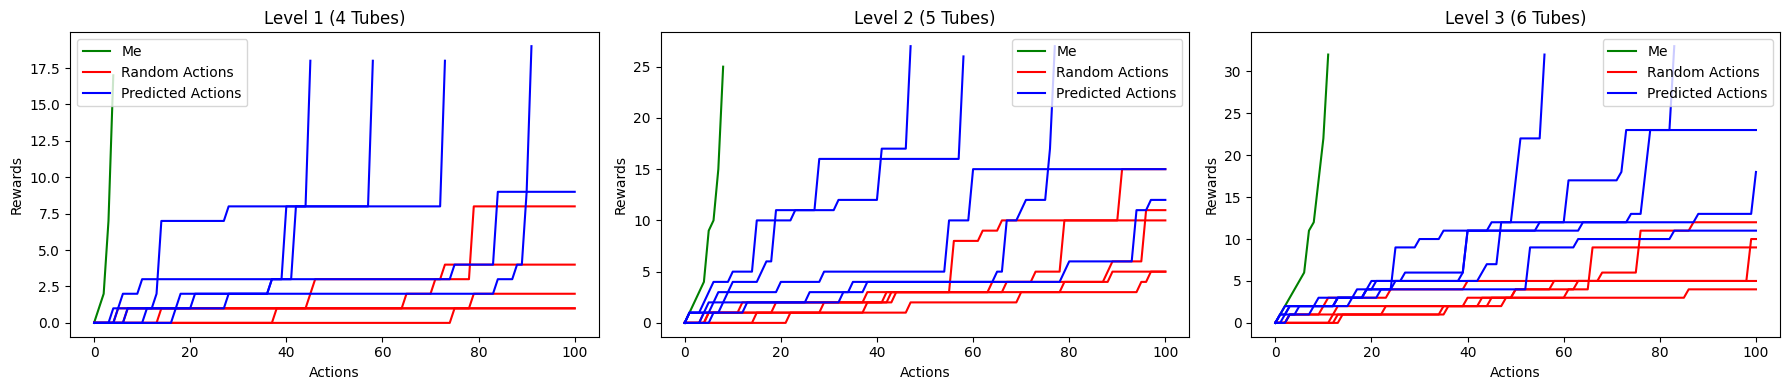

In [165]:
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.plot(level_1_human, color='green', label='Me')
for i, action in enumerate(level_1_random):
    if i == 0:
        plt.plot(action, color='red', label='Random Actions')
    else:
        plt.plot(action, color='red')
for i, action in enumerate(level_1_model):
    if i == 0:
        plt.plot(action, color='blue', label='Predicted Actions')
    else:
        plt.plot(action, color='blue')
plt.ylabel('Rewards')
plt.xlabel('Actions')
plt.legend()
plt.title('Level 1 (4 Tubes)')



plt.subplot(1, 3, 2)
plt.plot(level_2_human, color='green', label='Me')
for i, action in enumerate(level_2_random):
    if i == 0:
        plt.plot(action, color='red', label='Random Actions')
    else:
        plt.plot(action, color='red')
for i, action in enumerate(level_2_model):
    if i == 0:
        plt.plot(action, color='blue', label='Predicted Actions')
    else:
        plt.plot(action, color='blue')
plt.ylabel('Rewards')
plt.xlabel('Actions')
plt.legend()
plt.title('Level 2 (5 Tubes)')



plt.subplot(1, 3, 3)
plt.plot(level_3_human, color='green', label='Me')
for i, action in enumerate(level_3_random):
    if i == 0:
        plt.plot(action, color='red', label='Random Actions')
    else:
        plt.plot(action, color='red')
for i, action in enumerate(level_3_model):
    if i == 0:
        plt.plot(action, color='blue', label='Predicted Actions')
    else:
        plt.plot(action, color='blue')
plt.ylabel('Rewards')
plt.xlabel('Actions')
plt.legend()
plt.title('Level 3 (6 Tubes)')



plt.tight_layout()
plt.show()